## Martin Dionne

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import requests
import json
import re
import gensim
import gensim.downloader as model_api
from statistics import mode

# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [9]:
import string 
from sklearn.feature_extraction import text

df = pd.read_csv("data/app_reviews.csv")
df['comment'] = df['comment'].str.lower().str.replace('[{}]'.format(string.punctuation),'')
df.sample(10)

<ipython-input-9-abee59ccf720>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment'] = df['comment'].str.lower().str.replace('[{}]'.format(string.punctuation),'')


,app,country,version,rating,comment
5347,candycrush,tt,1.104.0,5,awesome
136,candycrush,au,1.180.0.1,1,candy crush is a terrible game and i would not...
10158,twitter,us,8.54.5,2,poor navigation needs better flow obviously i...
5652,tinder,au,11.29.0,1,i was banned for no reason i’m 18 and just dec...
16596,facebook,nz,297.0,2,i would like to be able to go back to classic ...
21151,facebook,jm,5.0.1,5,i really love this app especially the updates ...
17611,facebook,gh,6.2,4,great app by all standards love it
16753,facebook,nz,276.0,1,the new version of facebook doesn’t work on my...
8403,tinder,ie,11.6.0,1,crashes constantly every few swipes iphone 7 i...
688,candycrush,us,1.196.0.1,2,app updated earlier this week wouldn’t load ap...


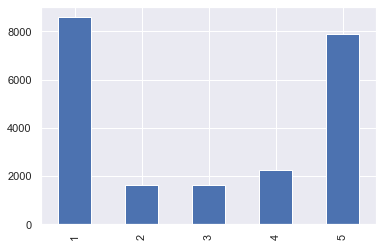

In [10]:
df.rating.value_counts().plot(kind='bar');

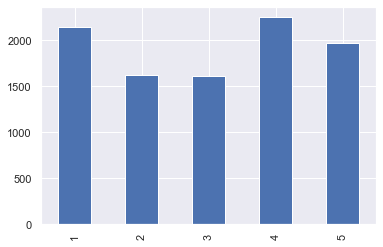

In [11]:
# the dataset is quite unbalanced, so let's subsample 1 and 5 ratings
dx = df.drop(df['rating'][df['rating'] == 1].sample(frac=0.75, random_state=42).index)
dx = dx.drop(dx['rating'][df['rating'] == 5].sample(frac=0.75, random_state=42).index)
dx.rating.value_counts().plot(kind='bar');

In [16]:
# 1.1 Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

import sklearn.cluster as clu
from sklearn import metrics
from sklearn import preprocessing as pre
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import statsmodels.api as sm

# remove frequent words (max_df=0.95) and very rare words (min_df=2)
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = tfidf.fit_transform(dx['comment'])

#from sklearn.preprocessing import Normalizer
#Xd = Normalizer().fit_transform(X)

#Xd = X.toarray()
#Xd = PCA(30).fit(Xd)

kmeans = clu.KMeans(n_clusters=5, random_state=42).fit(X)
labels = kmeans.fit_predict(X)
# labels from  0 to 4 should be 1 to 5
labels = labels + 1

In [17]:
# correct prediction labeling
y_pred = labels.copy()
for i in range(1,6):
    y_pred[labels == i] = mode(dx.rating[labels == i])

# classification metrics
y = dx['rating']
print(metrics.confusion_matrix(y, y_pred))
print(metrics.classification_report(y, y_pred))
print("OLS R^2: ", metrics.r2_score(y, y_pred))

[[2072    0    0   75    2]
 [1533    0    0   90    3]
 [1455    0    0  125   36]
 [1720    0    0  386  147]
 [1358    0    0  381  233]]
              precision    recall  f1-score   support

           1       0.25      0.96      0.40      2149
           2       0.00      0.00      0.00      1626
           3       0.00      0.00      0.00      1616
           4       0.37      0.17      0.23      2253
           5       0.55      0.12      0.19      1972

    accuracy                           0.28      9616
   macro avg       0.23      0.25      0.17      9616
weighted avg       0.26      0.28      0.18      9616

OLS R^2:  -1.2820648818657499
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# 1.2 Now use a sentence embedding using on of the gensim pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale target using all unsupervised methods you want.

replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = dx.comment.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words.head()

,0,1,2,3,4,5,6,7,8,9,...,409,410,411,412,413,414,415,416,417,418
0,i,enjoy,candy,crush,great,stress,reliever,but,since,when,...,None,None,None,None,None,None,None,None,None,None
1,i,just,lost,all,my,boosters,i,was,stock,piling,...,None,None,None,None,None,None,None,None,None,None
2,i,had,to,break,my,addiction,to,toon,blast,after,...,None,None,None,None,None,None,None,None,None,None
3,it’s,good,game,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,long,time,player,but,lately,i’ve,noticed,that,when,i,...,None,None,None,None,None,None,None,None,None,None


In [19]:
# Load pretrained word embeddings
word_vectors = model_api.load("glove-wiki-gigaword-200")

def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)
        
def map_vectors(row):
    if np.sum(row.notna()) == 0:
        return np.zeros(word_vectors.vector_size)
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)
        
emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())
emb

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,2.659573,6.060144,-6.116351,-4.950160,0.401843,0.786568,-7.871712,-0.963467,1.576874,3.525024,...,-3.190559,-0.190582,-2.378934,1.828707,3.280392,1.562207,0.065863,3.640778,-3.054910,1.525520
1,3.546710,14.299687,-11.160658,-7.528004,-5.743996,4.218500,-17.723080,-0.965646,1.840857,14.670384,...,-8.192076,1.682919,-7.567513,5.787020,8.078144,-2.577827,0.319647,2.333745,-7.295327,8.951132
2,10.309269,17.163466,-13.395695,-18.384949,-2.219403,9.727720,-32.492077,-2.550215,7.914015,24.800201,...,-12.881126,4.335192,-10.613461,5.164815,13.186735,-4.738437,-0.425536,11.275290,-10.110826,10.452630
3,0.480331,1.028330,-0.970200,0.115775,-0.713560,0.096860,-0.548806,-0.180042,0.514650,1.003960,...,0.143161,-1.091810,-0.119860,0.363785,0.433900,0.127150,-0.357339,0.201693,-0.633769,0.016090
4,6.824396,8.977546,-11.694278,-8.583594,2.888558,-0.741326,-17.843566,-4.308581,0.545578,7.971781,...,-7.819976,2.615578,-8.852869,3.689718,8.400197,0.427958,-1.465005,5.225886,-7.264063,5.621810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9611,0.515070,0.355960,0.157100,-0.074075,-0.254460,-0.113570,-0.499430,-0.126260,0.388510,0.542040,...,-0.048109,-0.380570,-0.352580,-0.006266,0.272270,-0.162220,-0.319790,0.143380,-0.072859,0.178150
9612,22.329522,21.713016,-6.089360,-20.624410,0.200359,0.645838,-36.328907,-3.609237,14.545269,18.346897,...,-12.719829,-3.180410,-11.693861,8.886115,12.774969,-7.139848,-4.637975,19.384256,-7.408388,5.076003
9613,1.887215,1.073778,-0.991917,-2.136620,0.723490,0.233031,-3.131542,-1.447925,-2.119696,2.159788,...,-2.047560,0.262330,-0.877016,1.381860,1.421185,-0.180429,-0.159329,1.115250,-0.178860,1.953573
9614,6.319409,8.719551,-2.814865,-6.794538,2.755433,-0.651483,-11.022708,0.471595,-0.646937,7.789625,...,-1.882557,-2.268779,-4.509701,2.823983,2.212838,-2.086598,-2.033760,3.807225,-3.218776,2.726923


In [20]:
from sklearn.preprocessing import Normalizer
emb_scaled = Normalizer().fit_transform(emb)

In [21]:
kmeans = clu.KMeans(n_clusters=5, random_state=42).fit(emb_scaled)
labels_2 = kmeans.fit_predict(emb_scaled)
# labels from  0 to 4 should be 1 to 5
labels_2 = labels_2 + 1

In [22]:
# correct prediction labeling
y_pred_2 = labels_2.copy()
for i in range(1,6):
    y_pred_2[labels_2 == i] = mode(dx.rating[labels_2 == i])

# classification metrics
y = dx['rating']
print(metrics.confusion_matrix(y, y_pred_2))
print(metrics.classification_report(y, y_pred_2))
print("OLS R^2: ", metrics.r2_score(y, y_pred_2))

[[1266    0    0  684  199]
 [ 949    0    0  567  110]
 [ 824    0    0  610  182]
 [ 921    0    0  702  630]
 [ 581    0    0  570  821]]
              precision    recall  f1-score   support

           1       0.28      0.59      0.38      2149
           2       0.00      0.00      0.00      1626
           3       0.00      0.00      0.00      1616
           4       0.22      0.31      0.26      2253
           5       0.42      0.42      0.42      1972

    accuracy                           0.29      9616
   macro avg       0.19      0.26      0.21      9616
weighted avg       0.20      0.29      0.23      9616

OLS R^2:  -0.8160425906968334
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# 1.3 Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best regression model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

import scipy as sc

Xd = X.toarray()
Xd = PCA(200).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ dx['rating'].values
print("OLS R^2: ", metrics.r2_score(dx['rating'], pred))

OLS R^2:  0.4091471958569981


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xd, y, test_size=0.15, random_state=42)

In [25]:
# 1.4 Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                        n_estimators=300, learning_rate=0.25)

ada.fit(X_train, y_train)

y_pred_4 = ada.predict(X_test)

In [26]:
# classification metrics
y = dx['rating']
print(metrics.confusion_matrix(y_test, y_pred_4))
print(metrics.classification_report(y_test, y_pred_4))
print("OLS R^2: ", metrics.r2_score(y_test, y_pred_4))

[[204  57  20  24  13]
 [ 97  67  27  33   5]
 [ 88  54  36  62  13]
 [ 56  28  34 129  93]
 [ 32   6  11 102 152]]
              precision    recall  f1-score   support

           1       0.43      0.64      0.51       318
           2       0.32      0.29      0.30       229
           3       0.28      0.14      0.19       253
           4       0.37      0.38      0.37       340
           5       0.55      0.50      0.53       303

    accuracy                           0.41      1443
   macro avg       0.39      0.39      0.38      1443
weighted avg       0.40      0.41      0.39      1443

OLS R^2:  0.06936410271798654


## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [15]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30, resize=0.25, color=False)

data = faces.data
#target = faces.target
images = faces.images
print(images.shape)

(2370, 31, 23)


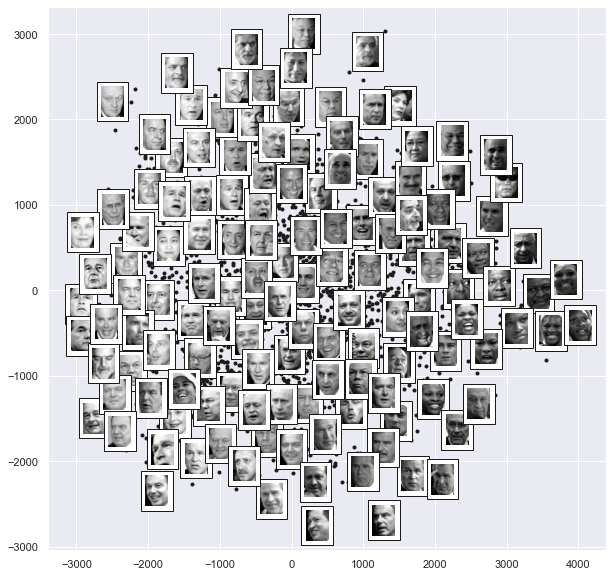

In [16]:

from sklearn.manifold import Isomap
from matplotlib import offsetbox
#import umap

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),proj[i])
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
#model = umap.UMAP(n_neighbors=4, n_components=2, random_state=92)
model = Isomap(n_components=2)
plot_components(data, model, images=images, ax=ax, thumb_frac=0.05)